# Parameter Estimation Methods on Double Pendulum  Control Tasks

## Import packages

In [241]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.numpy as sqrt
from autograd.numpy.linalg import norm
from autograd.numpy.linalg import inv
from autograd import jacobian
from autograd.test_util import check_grads
from collections import deque
np.set_printoptions(precision=4, suppress=True)
# Note: autograd does not work with np.block

## Double Pendulum Dynamics

In [499]:

from matplotlib.animation import FuncAnimation
class Double_Pendulum():
    def __init__(self):
        self.m1, self.m2 = 1, 1  # masses
        self.l1, self.l2 = 1.0, 1.0  # lengths
        self.g = 9.81  # gravity
        self.A_jac = jacobian(self.double_pen_rk4, 0) 
        self.B_jac = jacobian(self.double_pen_rk4, 1)
        
        self.max_dev_x = np.array([np.pi / 2, 1.0, np.pi / 2, 1.0])  # max deviations for states
        self.max_dev_u = np.array([50.0, 0.0001])  # max control effort

    def double_pendulum_dynamics(self, state, m1, m2, l1, l2, g, u):
        #https://dassencio.org/33 equations of motion
        # theta1, omega1, theta2, omega2 = state
        
        # delta = theta2 - theta1
        

        # # Compute alpha1, alpha2
        # alpha1 = (l2 / l1) * (m2 / (m1 + m2)) * np.cos(delta)
        # alpha2 = (l1 / l2) * np.cos(delta)

        # # # Compute f1 and f2
        # # f1 = (-l2 / l1) * (m2 / (m1 + m2)) * omega2**2 * np.sin(delta) - (g / l1) * np.sin(theta1)
        # # # print("f2", (l1 / l2) * omega1**2 * np.sin(delta) - (g / l2) * np.sin(theta2), "u", u/l2)
        # # f2 = (l1 / l2) * omega1**2 * np.sin(delta) - (g / l2) * np.sin(theta2)+(u[0]/l2)
        
        
        # f1 = (-l2 / l1) * (m2 / (m1 + m2)) * omega2**2 * np.sin(delta) - (g / l1) * np.sin(theta1) + (u[0] / l1)
        # f2 = (l1 / l2) * omega1**2 * np.sin(delta) - (g / l2) * np.sin(theta2)

        # # Matrix A and its determinant
        # detA = 1 - alpha1 * alpha2
        # A_inv = (1 / detA) * np.array([[1, -alpha1], [-alpha2, 1]])

        # # Solve for angular accelerations
        # rhs = np.array([f1, f2])
        # angular_accels = A_inv @ rhs

        # omega1_dot, omega2_dot = angular_accels

        # # Return the derivatives
        # return np.array([omega1, omega1_dot, omega2, omega2_dot])

        #https://bolundai0216.github.io/assets/images/control_theory/Feedback%20Linearization%20of%20Double%20Pendulum.pdf 
        theta1, omega1, theta2, omega2 = state
        delta = theta2 - theta1

        # Mass matrix M(q)
        M = np.array([
            [(m1 + m2) * l1**2, m2 * l1 * l2 * np.cos(delta)],
            [m2 * l1 * l2 * np.cos(delta), m2 * l2**2]
        ])

        # Coriolis and centrifugal forces C(q, q̇)q̇
        C = np.array([
            [0, m2 * l1 * l2 * omega2 * np.sin(delta)],
            [m2 * l1 * l2 * omega1 * np.sin(delta), 0]
        ])

        # Gravity vector G(q)
        G = np.array([
            [(m1 + m2) * g * l1 * np.sin(theta1)],
            [m2 * g * l2 * np.sin(theta2)]
        ])

        # Compute acceleration: q̈ = M⁻¹ (τ - C - G)
        qdot = np.array([
            [omega1],
            [omega2]
        ])
        # print("M ", M)
        
        # print("C", C)
        # print("G", G)
        # print("u", u)
      #  print("Determinant of M:", np.linalg.det(M))
      
        M_inv = np.linalg.inv(M)
        #print("omega: ", omega1,omega2, C)
        torque = M@u + C@qdot +G
        qddot = -M_inv @ (C @ qdot + G) + M_inv @ torque
        return np.array([omega1, qddot[0][0], omega2, qddot[1][0]])
    # Runge-Kutta 4th order integration
    def double_pen_rk4(self, x, u, m1, m2, l1, l2, g):
        h = 0.001
       # x=np.ravel(x)
       # print("doublepenrk4: ",x[0])
        k1 = self.double_pendulum_dynamics(x, m1, m2, l1, l2, g, u)
        k2 = self.double_pendulum_dynamics(x + 0.5 * h * k1, m1, m2, l1, l2, g, u)
        k3 = self.double_pendulum_dynamics(x + 0.5 * h * k2, m1, m2, l1, l2, g, u)
        k4 = self.double_pendulum_dynamics(x + h * k3, m1, m2, l1, l2, g, u)
        
        return x + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    # def get_swingup_goals(self, state, m1, m2, l1, l2, g):
    #     self.x = np.array([np.pi / 4, 0, 0, 0])
    #     return self.x

    def get_linearized_dynamics(self, xg, u, m1, m2, l1, l2, g):
      
        Anp = self.A_jac(xg, u, m1, m2, l1, l2, g) 
        Bnp = self.B_jac(xg, u, m1, m2, l1, l2, g).reshape(4,2) 
        #print(Anp,"b",Bnp)
    #    Bnp = Bnp / np.max(np.abs(Bnp))  # Normalize B to prevent LQR from overreacting

        
        self.Anp = Anp
        self.Bnp = Bnp
        return self.Anp, self.Bnp

## LQR Controller 

In [503]:
from scipy.linalg import solve_continuous_are

class LQRController():
    def __init__(self):
        pass

    def update_linearized_dynamics (self, Anp, Bnp, Q, R):
        self.Anp = Anp
        self.Bnp = Bnp
        self.Q = Q
        self.R = R

    def dlqr(self, A, B, Q, R, n_steps=100):
        """
        Solves the continuous-time algebraic Riccati equation to compute the optimal gain matrix K.
        """
        P = Q
        for i in range(n_steps):
            K = inv(R + B.T @ P @ B) @ B.T @ P @ A
            P = Q + A.T @ P @ (A - B @ K)
        # A_norm = A / (np.max(np.abs(A)) + 1e-6)
        # B_norm = B / (np.max(np.abs(B)) + 1e-6)
        # Q_norm = Q / (np.max(np.abs(Q)) + 1e-6)
        # R_norm = R / (np.max(np.abs(R)) + 1e-6)

        # P = solve_continuous_are(A_norm, B_norm, Q_norm, R_norm)
        # K = np.linalg.inv(R_norm) @ B_norm.T @ P

        return K, P
    
    def get_QR_bryson(self):
        max_dev_x = np.array([np.pi , 1.0, np.pi/2, 1.0])  # max deviations for states
        max_dev_u = np.array([30.0, 0.00001])  # max control effort
        Q = np.diag(1./max_dev_x**2)
        R = np.diag(1./max_dev_u**2)
        print("Q: ", Q, "R: ", R)
        return Q, R
    def compute(self, x_curr, x_desired):
        """
        Compute control input using the LQR gain matrix.
        Returns:
            control_input: Control input to stabilize the system.
        """
        K_lqr, P_lqr = self.dlqr(self.Anp, self.Bnp, self.Q, self.R)
        delta_x = x_curr - x_desired
        print("deltax: ", delta_x)
        print("K_lqr: ", K_lqr)
        print("control", K_lqr @ delta_x )
        return K_lqr @ delta_x




# Simulation

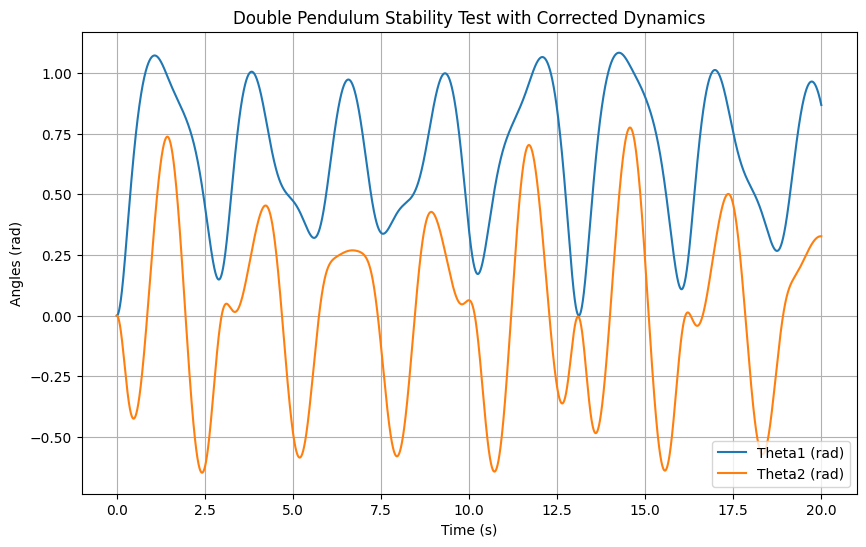

In [500]:
import matplotlib.pyplot as plt

# Initialize pendulum parameters
m1, m2 = 1.0, 1.0  # Masses
l1, l2 = 1.0, 1.0  # Lengths
g = 9.81  # Gravity

# Compute the correct stabilization torque
u_nom = (g * np.sqrt(2) / 2) * (m1 + m2) * l1

# Initial state: [theta1, omega1, theta2, omega2]
initial_state = np.array([0, 0, 0, 0])

# Simulate for 10 seconds
dt = 0.001 # Time step
NSIM = int(20 / dt)  # Number of steps

# Store results
state_history = [initial_state]
time_history = [0]

# Create pendulum object
pendulum = Double_Pendulum()

# Run the simulation with constant stabilization torque
x_curr = initial_state
rg = list(range(0, NSIM))  
for i in range(NSIM):
    if i in rg:
        x_curr = pendulum.double_pen_rk4(x_curr, np.array([[10],[0]]), m1, m2, l1, l2, g)
    else: 
        x_curr = pendulum.double_pen_rk4(x_curr, np.array([[0],[0]]), m1, m2, l1, l2, g)
    state_history.append(x_curr)
    time_history.append(time_history[-1] + dt)

# Convert to NumPy arrays
state_history = np.array(state_history)

# Plot the angles over time
plt.figure(figsize=(10, 6))
plt.plot(time_history, state_history[:, 0], label="Theta1 (rad)")
plt.plot(time_history, state_history[:, 2], label="Theta2 (rad)")
plt.xlabel("Time (s)")
plt.ylabel("Angles (rad)")
plt.title("Double Pendulum Stability Test with Corrected Dynamics")
plt.legend()
plt.grid()
plt.show()


Q:  [[0.1013 0.     0.     0.    ]
 [0.     1.     0.     0.    ]
 [0.     0.     0.4053 0.    ]
 [0.     0.     0.     1.    ]] R:  [[1.1111e-03 0.0000e+00]
 [0.0000e+00 1.0000e+10]]
0
deltax:  [-0.7854  0.      0.      0.    ]
K_lqr:  [[-11.0469  23.629   10.5529 -16.2287]
 [  0.       0.      -0.       0.    ]]
control [ 8.6762 -0.    ]
u =  [[ 8.6762]
 [-0.    ]]
A matrix:
 [[ 1.      0.001   0.      0.    ]
 [-0.0092  1.      0.0046  0.    ]
 [ 0.      0.      1.      0.001 ]
 [ 0.0065  0.     -0.0131  1.    ]]
B matrix:
 [[ 0.     -0.    ]
 [ 0.0007 -0.0005]
 [-0.      0.    ]
 [-0.0005  0.0013]]
1
deltax:  [-0.7854  0.0087 -0.     -0.0087]
K_lqr:  [[-11.0469  23.629   10.5529 -16.2287]
 [  0.       0.      -0.       0.    ]]
control [ 9.0219 -0.    ]
u =  [[ 9.0219]
 [-0.    ]]
A matrix:
 [[ 1.      0.001   0.      0.    ]
 [-0.0092  1.      0.0046  0.    ]
 [ 0.      0.      1.      0.001 ]
 [ 0.0065  0.     -0.0131  1.    ]]
B matrix:
 [[ 0.     -0.    ]
 [ 0.0007 -0.0005]
 [-

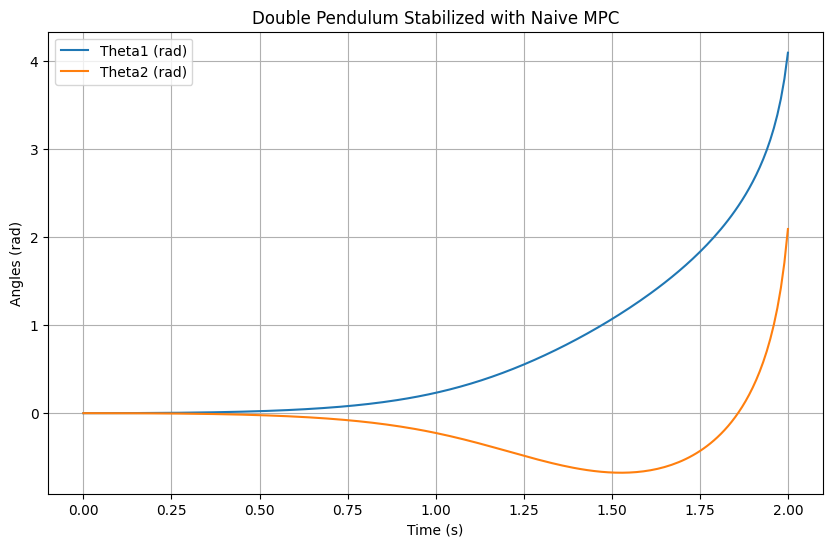

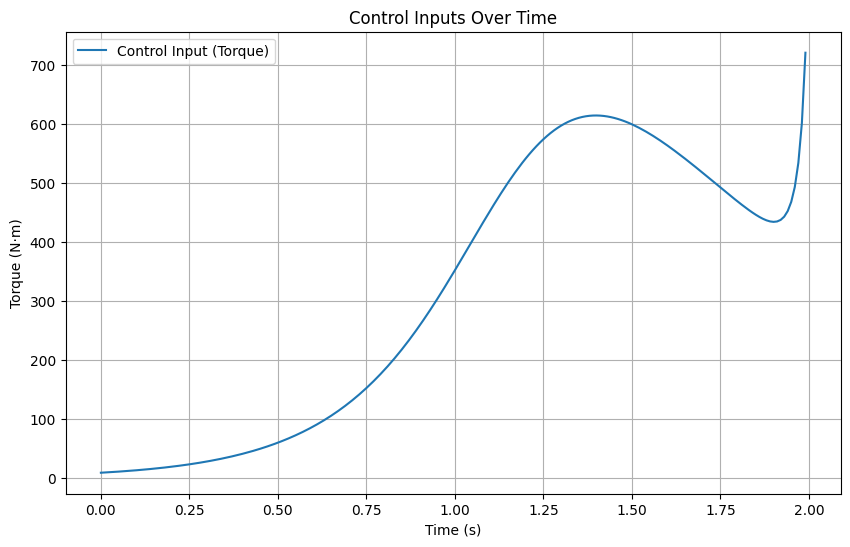

In [504]:
pendulum = Double_Pendulum()
pendulum_controller = LQRController ()
def simulate_with_controller_naive_MPC(pendulum, pendulum_controller, x0, x_nom, update_status="immediate_update", NSIM=200):
    """
    Simulates the double pendulum dynamics using an MPC approach with an LQR controller.
    
    Args:
        pendulum: Instance of the Double_Pendulum class.
        lqr_controller: Instance of the LQR_Controller class.
        x0: Initial state of the system.
        x_nom: Desired state of the system.
        NSIM: Number of simulation steps.
        
    Returns:
        x_all: Array of system states over time.
        u_all: Array of control inputs over time.
    """

    x_all = []
    u_all = []
    theta_all = []
    x_curr = np.copy(x0)
    x_prev = np.copy(x0)
    u_curr = np.array([[5],
                       [0]])
    x_all.append(x_curr)
    u_all.append(u_curr)
    m1, m2, l1, l2, g = pendulum.m1, pendulum.m2, pendulum.l1, pendulum.l2, pendulum.g
    u_nom = np.array([
    [(m1 + m2) * g * l1 * np.sin(np.pi / 4)], 
    [0]  # No steady-state torque for the second joint
    ])

    Anp, Bnp = pendulum.get_linearized_dynamics(x_nom, u_nom , m1, m2, l1, l2, g)
    Q, R = pendulum_controller.get_QR_bryson()
    # print("Q here is ", Q, "R here is ", R)
    pendulum_controller.update_linearized_dynamics(Anp, Bnp, Q, R)
    
    max_u_curr = 20  # Increased torque for better control

    change_params = False
   
    
    for i in range(NSIM):
        # Change gravity at step 50
        print(i)
        if i == 50:
            change_params = True
            g = 1 * g  # Double gravity
        if update_status == "immediate_update":
            u_curr = pendulum_controller.compute(x_curr, x_nom)
            u_curr=np.array([
                [u_curr[0]],
                [u_curr[1]]
            ])
            print("u = ", u_curr)
            Anp, Bnp = pendulum.get_linearized_dynamics(x_nom, u_nom, m1, m2, l1, l2, g)
            pendulum_controller.update_linearized_dynamics(Anp, Bnp, Q, R)
            print("A matrix:\n", Anp)
            print("B matrix:\n", Bnp)

        else:
            print("invalid update status. Choose from 'immediate_update', 'never_update', or 'late_update'.")
            exit()

        theta = g
        # print("step: ", i, "\n", 
        #         "u_k: ", u_curr, "\n", 
        #         "x_k: ", x_prev, "\n", 
        #         "theta_k: ", g, "\n", 
        #         )
        u_curr[1] = 0
        x_prev = x_curr
        x_curr = pendulum.double_pen_rk4(x_curr, u_curr, m1, m2, l1, l2, g)

        x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
        x_all.append(x_curr)
        u_all.append(u_curr)
        theta_all.append(theta)
    return x_all, u_all, theta_all



# **Initialize the Double Pendulum and Controller**
pendulum = Double_Pendulum()
pendulum_controller = LQRController()

# **Define Initial and Target States**
desired_state = np.array([np.pi / 4, 0, 0, 0])  # Swing to 45 degrees
initial_state = np.array([0,0,0,0])  # Small deviation from rest

# **Run the Simulation**
x_all, u_all, theta_all = simulate_with_controller_naive_MPC(
    pendulum, pendulum_controller, initial_state, desired_state, update_status="immediate_update"
)

# **Convert Results to NumPy Arrays**
x_all = np.array(x_all)
u_all = np.array(u_all)

# **Plot Theta1 and Theta2 Over Time**
nsteps = len(x_all)
time = np.arange(nsteps) * 0.01  # Assuming dt = 0.01

plt.figure(figsize=(10, 6))
plt.plot(time, x_all[:, 0], label="Theta1 (rad)")  # Upper pendulum angle
plt.plot(time, x_all[:, 2], label="Theta2 (rad)")  # Lower pendulum angle
plt.xlabel("Time (s)")
plt.ylabel("Angles (rad)")
plt.title("Double Pendulum Stabilized with Naive MPC")
plt.legend()
plt.grid()
plt.show()
u1_all = u_all[1:, 0]
# **Plot Control Inputs Over Time**
plt.figure(figsize=(10, 6))
plt.plot(time[:-1], u1_all, label="Control Input (Torque)")
plt.xlabel("Time (s)")
plt.ylabel("Torque (N·m)")
plt.title("Control Inputs Over Time")
plt.legend()
plt.grid()
plt.show()


control [-12.2139]
step:  0 
 controls:  [-12.2139] 
 position:  [ 0.1  0.  -0.1  0. ]
control [-10.1694]
step:  1 
 controls:  [-10.1694] 
 position:  [0.10086974242439539, 0.08686772920822762, -0.10197514884130837, -0.19733983899202254]
control [-8.528]
step:  2 
 controls:  [-8.528] 
 position:  [0.10240970584317173, 0.15380674374259942, -0.10552136607712426, -0.35431207504730555]
control [-7.215]
step:  3 
 controls:  [-7.215] 
 position:  [0.10445723352215987, 0.2044999099895697, -0.11031007042959007, -0.47845890199996444]
control [-6.1694]
step:  4 
 controls:  [-6.1694] 
 position:  [0.10687984775525804, 0.24196170987202004, -0.11607442505958168, -0.5759484068375137]
control [-5.3414]
step:  5 
 controls:  [-5.3414] 
 position:  [0.10956973477834372, 0.2686553246101434, -0.12259801472818031, -0.6518172810300692]
control [-4.6904]
step:  6 
 controls:  [-4.6904] 
 position:  [0.11243920664315026, 0.2865906108498047, -0.1297055470866405, -0.7101733524925475]
control [-4.1832]
step

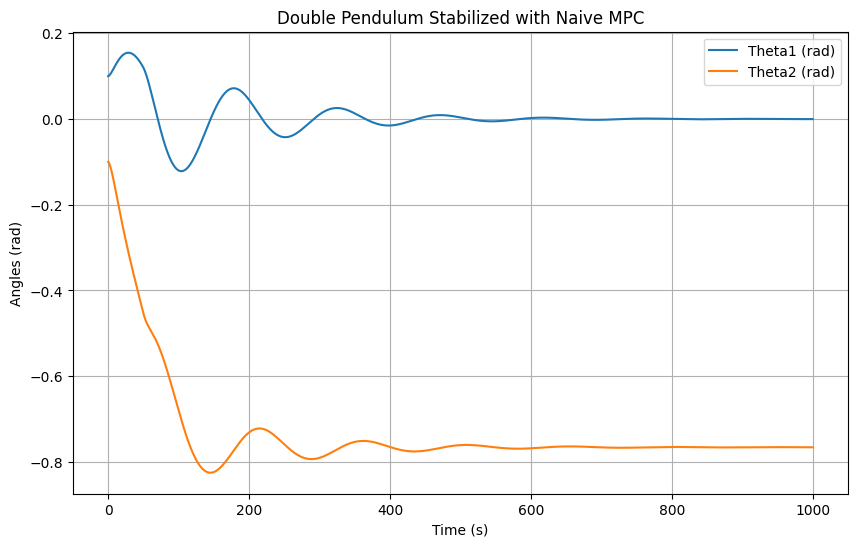

In [61]:
#simulate with naive MPC
pendulum = Double_Pendulum()
def simulate_double_pendulum_with_Naive_MPC(self, update_status: str, NSIM: int =200):
    #initialize double pendulum parameters
    theta = np.array()
    x_all = []
    u_all = []
    x_curr = np.copy(x0)
    x_all.append(x_curr)
    max_u_curr = 10


    change_params = False

    # simulate the dynamics with the LQR controller
    for i in range(NSIM):
        # change mass
        if i == 50:
            change_params = True
            # mass_new = 2*mass
            g_new = 2*g
            u_nom_new = np.array([0.0])

        # MPC controller
        if i >= 60:
            u_curr = controller(x_curr, x_nom, u_nom_new)
        else:
            u_curr = controller(x_curr, x_nom, u_nom)
        if u_curr > max_u_curr:
            u_curr = max_u_curr
        print("step: ", i, "\n", "controls: ", u_curr, "\n", "position: ", x_curr)
      #  print(u_curr.shape)
        # postponing the dynamics model by telling it the correct parameters after several steps
        if change_params:
            x_curr = double_pen_rk4(x_curr, u_curr, m1, m2, l1, l2, g_new)
        else:
            x_curr = double_pen_rk4(x_curr, u_curr, m1, m2, l1, l2, g)

        x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
        u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

        x_all.append(x_curr)
        u_all.append(u_curr)
    
    return x_all, u_all

desired_state = np.array([np.pi / 4, 0, 0, 0])
initial_state = np.array([0.1,0,-0.1,0])  # Target state (downward position)

# Simulate the system using the naive MPC controller
x_all, u_all = simulate_with_controller_naive_MPC(initial_state, desired_state,  lqr_controller)
x_all = np.array(x_all)
# Visualizations
nsteps = len(x_all)
steps = np.arange(nsteps)
plt.figure(figsize=(10, 6))
plt.plot(steps, x_all[:, 0], label="Theta1 (rad)")
plt.plot(steps, x_all[:, 2], label="Theta2 (rad)")
plt.xlabel("Time (s)")
plt.ylabel("Angles (rad)")
plt.title("Double Pendulum Stabilized with Naive MPC")
plt.legend()
plt.grid()
plt.show()

Auxilary methods

In [62]:
def df_dg(x, u, m1, m2, l1, l2, g, h=1e-5):
    f_g = double_pen_rk4(x, u, m1, m2, l1, l2, g)

    f_g_plus_h = double_pen_rk4(x, u, m1, m2, l1, l2, g+h)

    df_dg = (f_g_plus_h - f_g) / h

    return df_dg
#can implement other gradients, implementing df_dm1g as an example
def df_dmg(x, u, m1, m2, l1, l2, g, h=1e-7):
    dfdm = np.zeros((x.shape[0], 2))
    dfdg = np.zeros((x.shape[0], 2))

    # Perturb mass (m)
    for i in range(x.shape[0]):
        x_plus_m = double_pen_rk4(x, u, m1 + h, m2, l1, l2, g)
        x_minus_m = double_pen_rk4(x, u, m1 - h, m2, l1, l2, g)
        dfdm[:, 0] = (x_plus_m - x_minus_m).flatten() / (2 * h)

    # Perturb gravity (g)
    for i in range(x.shape[0]):
        x_plus_g = double_pen_rk4(x, u, m1, m2, l1, l2, g + h)
        x_minus_g = double_pen_rk4(x, u, m1, m2, l1, l2, g - h)
        dfdg[:, 1] = (x_plus_g - x_minus_g).flatten() / (2 * h)
    
    # Combine into a single matrix
    dfdtheta = np.zeros((x.shape[0], 2))
    dfdtheta[:, 0] = dfdm[:,0]  # df/dm in the first column
    dfdtheta[:, 1] = dfdg[:,1]  # df/dg in the second column

    return dfdtheta

# function to visualize the trajectory
def visualize_trajectory_with_theta(x_all, u_all, theta_hat_all, theta_all, title):
    # Set up the figure and axis for plotting
    fig, ax = plt.subplots(3, 1)

    # Plot the trajectory
    x_all = np.array(x_all)
    nsteps = len(x_all)
    steps = np.arange(nsteps)
    ax[0].plot(steps, x_all[:, 0], label="Theta1 (rad)", linewidth=2)
   # ax[0].plot(steps, x_all[:, 1], label="y", linewidth=2)
    ax[0].plot(steps, x_all[:, 2], label="Theta2 (rad)", linewidth=2)
    ax[0].legend()
    ax[0].title.set_text("Position")


    theta_all = np.array(theta_all)
    theta_hat_all = np.array(theta_hat_all)
    nsteps = len(theta_all)
    steps = np.arange(nsteps)
    ax[1].plot(steps, [array[:,0] for array in theta_all], label="theta", linewidth=2)
    ax[1].plot(steps, [array[:,0] for array in theta_hat_all], label="theta_hat", linewidth=2)
    ax[1].legend()
    ax[1].title.set_text("Param Estimates")

    u_all = np.array(u_all)
    nsteps = len(u_all)
    steps = np.arange(nsteps)
    ax[2].plot(steps, u_all[:, 0], label="u1", linewidth=2)
    # ax[2].legend()
    ax[2].title.set_text("Controls")

    plt.suptitle(title)
    plt.show()


## Parameter Estimation Methods

In [63]:
class NaiveRLS:
    def __init__(self, num_params, lambda_factor=0.97):
        self.num_params = num_params
        self.lambda_factor = lambda_factor
        self.theta = 0.                    # Parameter estimate
        self.P = 1000.                       # Large initial covariance matrix

    def update(self, x, y):
        # Reshape inputs to column vectors
        x = np.reshape(x, (13, 1))          # TODO: 13 is hard coded! Change this
        y = np.reshape(y, (13, 1))          # Compute Kalman gain
        P_x = self.P * x
        gain_denominator = self.lambda_factor + x.T @ P_x
        K = P_x / gain_denominator        # Update estimate
        y_pred = x * self.theta
        self.theta = self.theta + K.T @ (y - y_pred)        # Update covariance matrix
        self.P = (self.P - K.T @ x * self.P) / self.lambda_factor
        return self.theta

In [64]:
class EKF:
    def __init__(self, process_noise=1e-3, measurement_noise=1e-1):
        self.theta =0.                    # Initial gravity estimate
        self.P = 100.0                       # Initial covariance
        self.Q = process_noise                # Process noise covariance
        self.R = np.eye(13) * measurement_noise  # Measurement noise covariance

    def predict(self):
        # Prediction step
        self.P = self.P + self.Q

    def update(self, x, y):
        """
        x: 13x1 Jacobian vector (sensitivity of dynamics to gravity)
        y: 13x1 observation vector (state differences)
        """
        # Ensure x and y are column vectors
        x = np.reshape(x, (13, 1))
        y = np.reshape(y, (13, 1))
        print(x,y)
        # Innovation covariance
        S = (x @ (self.P * x.T)) + self.R
        # Kalman gain
        K = (self.P * x.T) @ np.linalg.inv(S)  # K is 1x13

        # Update state estimate
        self.theta = self.theta + (K @ y).item()
        print(self.theta)
        # Update covariance
        self.P = self.P - (K @ S @ K.T).item()
        return self.theta

In [65]:
class RK_v2:
    def __init__(self, alpha=0.3):
        self.alpha = alpha

    def iterate(self, A, b, x0, num_iterations, tol = 0.01):
        """
        A: (num_states, num_param)
        x: (num_param, 1)
        b: (num_states, 1)
        """
        self.A = A
        self.b = b
        self.m = A.shape[0]  # m is the number of rows, n is the number of columns
        self.n = A.shape[1]
        self.x = np.array([x0]).reshape(self.n,1)  # Initial estimate of solution
       # print(A.shape, b.shape, self.x.shape)
        # print("cond: ",np.linalg.cond(A))
        # print("A: ", self.A)
        # print("b: ", self.b)
        # print("x0: ", self.x)
        # col_norms = np.linalg.norm(A, axis=0, keepdims=True)

        # Normalize each column
        # A = A / col_norms
        # print("A= ", A)

        for _ in range(num_iterations):
            # Compute exponential weighting for the rows
            row_norms = np.linalg.norm(A,axis=1)**2
            # probabilities = row_norms / np.sum(row_norms)
            mask = (row_norms > 1e-6)
            # print(mask)
            exponential_weights =  mask * np.exp(self.alpha * row_norms)
            probabilities = exponential_weights / (np.sum(exponential_weights))
            i = np.random.choice(self.m, p = probabilities)            # Update rule using the selected row
            # print(i)
            #print(i)
            a_i = np.array(self.A[i]) #.reshape(13,1)
            b_i = np.array(self.b[i])#.reshape(1,13)
            residual = b[i] - np.dot(A[i], self.x)
            if np.abs(residual) < tol:
                print("Converged")
                break
            # residual = np.dot(self.A, self.x) - b
            
            # if np.abs(residual).sum() < tol:
            #     print("tolerance hit")
            #     break
            increment = ((b_i - np.dot(a_i,self.x)) / (np.linalg.norm(a_i)**2))*a_i
            increment = increment.reshape(self.n,1)
            # print( increment)
            self.x = self.x + increment
        return self.x

In [66]:
def entropy_score(df_dg_window, b_window):
    """
    Compute entropy-based score for a given window of (df_dg, b).
    Lower entropy means a more informative motion sample.
    """
    # import pdb; pdb.set_trace()
    # Convert deque lists into proper numpy arrays
    df_dg_window = np.vstack(df_dg_window)  # Shape (num_samples, 13)
    b_window = np.vstack(b_window)  # Shape (num_samples, 13)

    # Ensure they are 2D before stacking
    if df_dg_window.ndim == 1:
        df_dg_window = df_dg_window.reshape(-1, 1)
    if b_window.ndim == 1:
        b_window = b_window.reshape(-1, 1)

    # Stack and ensure it's 2D
    stacked_data = np.hstack((df_dg_window, b_window))  # Shape (num_samples, 26)
    cov_matrix = np.cov(stacked_data, rowvar=False)  # Compute covariance matrix

    # Compute entropy as log determinant of covariance matrix
    entropy = 0.5 * np.linalg.slogdet(cov_matrix)[1]
    return entropy


def simulate_with_controller_entropy_RK(x0, x_nom,  controller, u_nom = np.array([0]), NSIM=600):
    x_all, u_all, theta_all, theta_hat_all = [], [], [], []
    x_curr = np.copy(x0)

    # Initialize parameters

    theta_gt = np.array([[1.0], [9.81]]) # [m1, gravity] (2,)
    theta_hat = theta_gt.copy()
    theta_hat_prev = theta_gt.copy()

    changing_step = 100
    change_params, clear_history = False, False
    u_curr = controller(x0, x_nom, u_nom)

    rk = RK_v2()

    # Priority queue for history (fixed size)
    queue_size = 5
    df_dg_queue, b_queue = deque(maxlen=queue_size), deque(maxlen=queue_size)

    # Keep track of scores for removal
    score_queue = deque(maxlen=queue_size)

    # Simulation loop
    for i in range(NSIM):

        # Change system parameters at specific step
        if i == changing_step:
            change_params = True
            theta_gt = np.array([[1.0*2], [9.81*2]])  


        # Compute control
        u_nom = np.array([0.0])
        u_prev, x_prev, theta_hat_prev = u_curr, x_curr, theta_hat
        u_curr = controller(x_curr, x_nom, u_nom)

        x_curr = double_pen_rk4(x_curr, u_curr, theta_gt[0][0], m2, l1, l2, theta_gt[1][0])
        theta_all.append(theta_gt)

           

        # Compute updates for g_hat x, u, m1, m2, l1, l2
        print(theta_hat_prev[0][0], theta_hat_prev[1][0])
        dfdtheta_at_theta_prev = df_dmg(x_prev, u_prev, theta_hat_prev[0][0], m2, l1, l2, theta_hat_prev[1][0]) # shape: (num_states, num_params)
        f_at_theta_prev = double_pen_rk4(x_prev, u_prev, theta_hat_prev[0][0], m2, l1, l2, theta_hat_prev[1][0]) 
        b = (x_curr.reshape(-1,1) - f_at_theta_prev.reshape(-1,1) + np.dot(dfdtheta_at_theta_prev, theta_hat_prev)) # shape: (num_states,1) 

        if i%50 == 0:
            b_all = b
            dfdtheta_at_theta_prev_all = dfdtheta_at_theta_prev
        else:
            b_all = np.vstack((b_all, b))

            dfdtheta_at_theta_prev_all = np.vstack((dfdtheta_at_theta_prev_all, dfdtheta_at_theta_prev.reshape(-1,2)))
            #print("A: ", dfdtheta_at_theta_prev_all)
            #print("b:", b_all)
            print("theta_hat: ", theta_hat_prev)
            theta_hat = rk.iterate(dfdtheta_at_theta_prev_all, b_all, theta_hat_prev, 1000, 0.001)
            lsq_soln, residuals, rank, s = np.linalg.lstsq(dfdtheta_at_theta_prev_all, b_all, rcond=None)
            print("km soln: ", theta_hat)
            print("lsq soln: ", lsq_soln)

        # Store results
        x_all.append(x_curr.tolist())
        u_all.append(u_curr.tolist())
        theta_hat_all.append(theta_hat)

    return x_all, u_all, theta_hat_all, theta_all

In [67]:
x_lqr, u_lqr, theta_hat, theta = simulate_with_controller_entropy_RK(initial_state, desired_state, lqr_controller)
visualize_trajectory_with_theta(x_lqr, u_lqr, theta_hat, theta, "traj")

control [-12.2139]
control [-12.2139]
1.0 9.81
control [-10.1694]
1.0 9.81
theta_hat:  [[1.  ]
 [9.81]]
Converged
km soln:  [[0.9998]
 [9.8161]]
lsq soln:  [[ 0.6814]
 [22.6879]]
control [-8.528]
0.9998094112133437 9.816146045839492
theta_hat:  [[0.9998]
 [9.8161]]
Converged
km soln:  [[0.9998]
 [9.8161]]
lsq soln:  [[ 0.6511]
 [23.5155]]
control [-7.215]
0.9998094112133437 9.816146045839492
theta_hat:  [[0.9998]
 [9.8161]]
Converged
km soln:  [[1.4384]
 [9.8411]]
lsq soln:  [[ 0.8107]
 [19.1935]]
control [-6.1694]
1.4384293495191833 9.841051641111932
theta_hat:  [[1.4384]
 [9.8411]]
Converged
km soln:  [[0.9995]
 [9.8226]]
lsq soln:  [[ 0.9664]
 [15.4404]]
control [-5.3414]
0.9994708738146448 9.822561587070377
theta_hat:  [[0.9995]
 [9.8226]]
Converged
km soln:  [[1.4375]
 [9.858 ]]
lsq soln:  [[ 1.0233]
 [14.0063]]
control [-4.6904]
1.4374666194855252 9.858006569647022
theta_hat:  [[1.4375]
 [9.858 ]]
Converged
km soln:  [[1.2093]
 [9.8816]]
lsq soln:  [[ 1.0661]
 [13.0617]]
control 

C:\Users\User\AppData\Local\Temp\ipykernel_24764\1806177166.py:34: RuntimeWarning: invalid value encountered in divide
  probabilities = exponential_weights / (np.sum(exponential_weights))


ValueError: probabilities contain NaN

[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2.6857]]
[[3.1198 0.     2.6857 0.    ]
 [0.     3.1198 0.     2

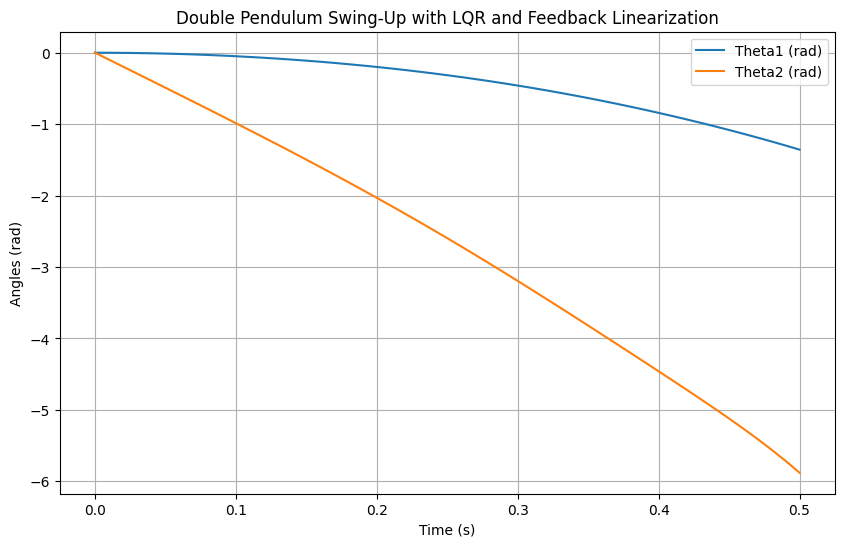